In [1]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl
import harmonypy as hm


import scanpy as sc

In [2]:
random_seed = 42
np.random.seed(random_seed)
sc.settings.seed = random_seed

# Step 0: Load the data

In [3]:
path_data_train = pl.Path("data/train_data")
path_data_test = pl.Path("data/test_data")

In [4]:
train_bulk = pd.read_csv(path_data_train / "train_bulk.csv",index_col=0)
train_bulk_trueprops = pd.read_csv(path_data_train / "train_bulk_trueprops.csv",index_col=0)
train_adata = sc.read_h5ad(path_data_train / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data_test / "test_adata.h5ad")
test_bulk = pd.read_csv(path_data_test / "test_bulk.csv",index_col=0)


In [5]:
print(f"Number of patients to deconvolve: {train_bulk.shape[1]}")
print(f"Number of genes in dataset: {train_bulk.shape[0]}")

Number of patients to deconvolve: 12
Number of genes in dataset: 7725


In [6]:
print(train_adata.obs.shape)
train_adata.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [7]:
train_adata.var.head()

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


(7725, 6)


<Axes: >

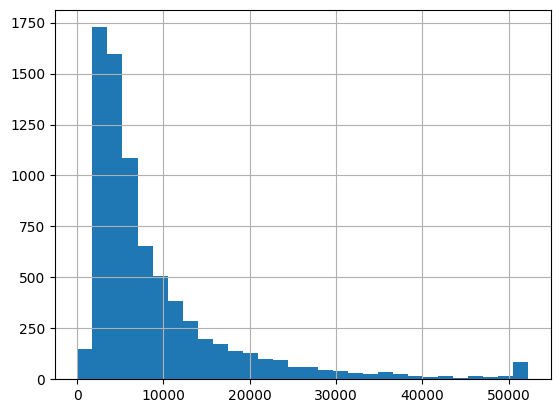

In [8]:
print(train_adata.var.shape)
train_adata.var["n_cells"].hist(bins=30)

In [9]:
print((train_adata.var["n_cells"] > 50_000).sum())

93


In [10]:
print(train_bulk.shape)
train_bulk.head()

(7725, 12)


,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


In [11]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [12]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


In [13]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs.Sample==spl].n_obs}")

Number of cells in the test set 18616
Number of cells for s5 is 6020
Number of cells for s6 is 5530
Number of cells for s9 is 3336
Number of cells for s10 is 3730


In [14]:
train_bulk.head()

,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


# Step 1: Deconvolve the data

In [32]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from scipy.optimize import nnls
# import warnings
# warnings.filterwarnings('ignore')

CELL_ORDER = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast', 'NK', 'Myeloid', 'Mast']  

def create_reference_matrix(true_props: pd.DataFrame, bulk_data: pd.DataFrame):
    ref_matrix = pd.DataFrame(
        index=bulk_data.index, # gene
        columns=true_props.index, # cell type
    )
    
    for gene in bulk_data.index:
        b = bulk_data.loc[gene].to_numpy()
        A = true_props.to_numpy().T
        
        gex, residual = nnls(A, b)
        
        ref_matrix.loc[gene] = gex
    
    return ref_matrix[CELL_ORDER]


# Improved deconvolution with data preprocessing
def deconvolve(bulk_data: pd.DataFrame, reference_matrix: pd.DataFrame):
    """
    Deconvolve bulk RNA-seq data with multiple method options.
    
    Parameters:
    - bulk_data: DataFrame with genes as rows, samples as columns
    - reference_matrix: DataFrame with genes as rows, cell types as columns
    Returns:
    - DataFrame with cell types as rows, samples as columns (proportions)
    """
    # Find common genes
    common_genes = bulk_data.index.intersection(reference_matrix.index)
    print(f"Using {len(common_genes)} common genes for deconvolution")
    
    # Subset to common genes
    bulk_subset = bulk_data.loc[common_genes].copy()
    ref_subset = reference_matrix.loc[common_genes].copy()
    
    
    # Initialize results
    proportions = pd.DataFrame(
        index=ref_subset.columns,
        columns=bulk_subset.columns
    )
    
    # Deconvolve each sample
    for sample in bulk_subset.columns:
        bulk_profile = bulk_subset[sample].to_numpy()
        ref_matrix = ref_subset.to_numpy()
        
        props, residual = nnls(ref_matrix, bulk_profile)
        
        # Normalize to sum to 1
        props = props / props.sum() if props.sum() > 0 else np.ones(len(props)) / len(props)
        proportions[sample] = props
    
    return proportions.loc[CELL_ORDER]


actual_ref_matrix = create_reference_matrix(train_bulk_trueprops, train_bulk)


train_props_pred = deconvolve(train_bulk, actual_ref_matrix)
actual_ref_matrix


Using 7725 common genes for deconvolution


highLevelType,T,Endothelial,Fibroblast,Plasmablast,B,Myofibroblast,NK,Myeloid,Mast
Unnamed: 0,,,,,,,,,
NOC2L,72.650217,0.0,751.621838,194.64674,56.401845,53.143105,264.457294,446.608312,0.0
HES4,279.370967,1014.446474,0.0,326.109088,0.0,1998.940732,404.09036,1110.125807,2928.220271
ISG15,971.050621,0.0,0.0,0.0,0.0,4545.634311,992.195807,3307.332015,5458.963773
TNFRSF18,0.0,0.0,0.0,0.0,602.695218,4816.102912,2400.796651,4629.321122,4649.718993
TNFRSF4,0.0,2760.212064,0.0,0.0,0.0,6275.473689,346.005474,1445.227048,2566.265266
...,...,...,...,...,...,...,...,...,...
MT-ND6,0.0,3032.867096,1340.434414,93.569869,86.768684,0.0,1327.196704,1401.239955,0.0
MT-CYB,20286.821766,118586.092299,26320.846467,41932.895335,0.0,0.0,55766.410256,33419.204833,0.0
SELE,0.0,7983.681771,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Evaluation on training data:
Mae mean: [0.02910689 0.00258356 0.00533184 0.00176431 0.00072232 0.02438624
 0.00049192 0.00038448 0.00023212]
Mean Absolute Error (MAE): 0.0488
Root Mean Squared Error (RMSE): 0.0850
Task Benchmark Score (TB): 0.0641

Per-cell-type MAE:
  T: 0.1334
  Fibroblast: 0.0462
  NK: 0.0567
  Myeloid: 0.0345
  Mast: 0.0202
  B: 0.1031
  Myofibroblast: 0.0191
  Endothelial: 0.0168
  Plasmablast: 0.0094


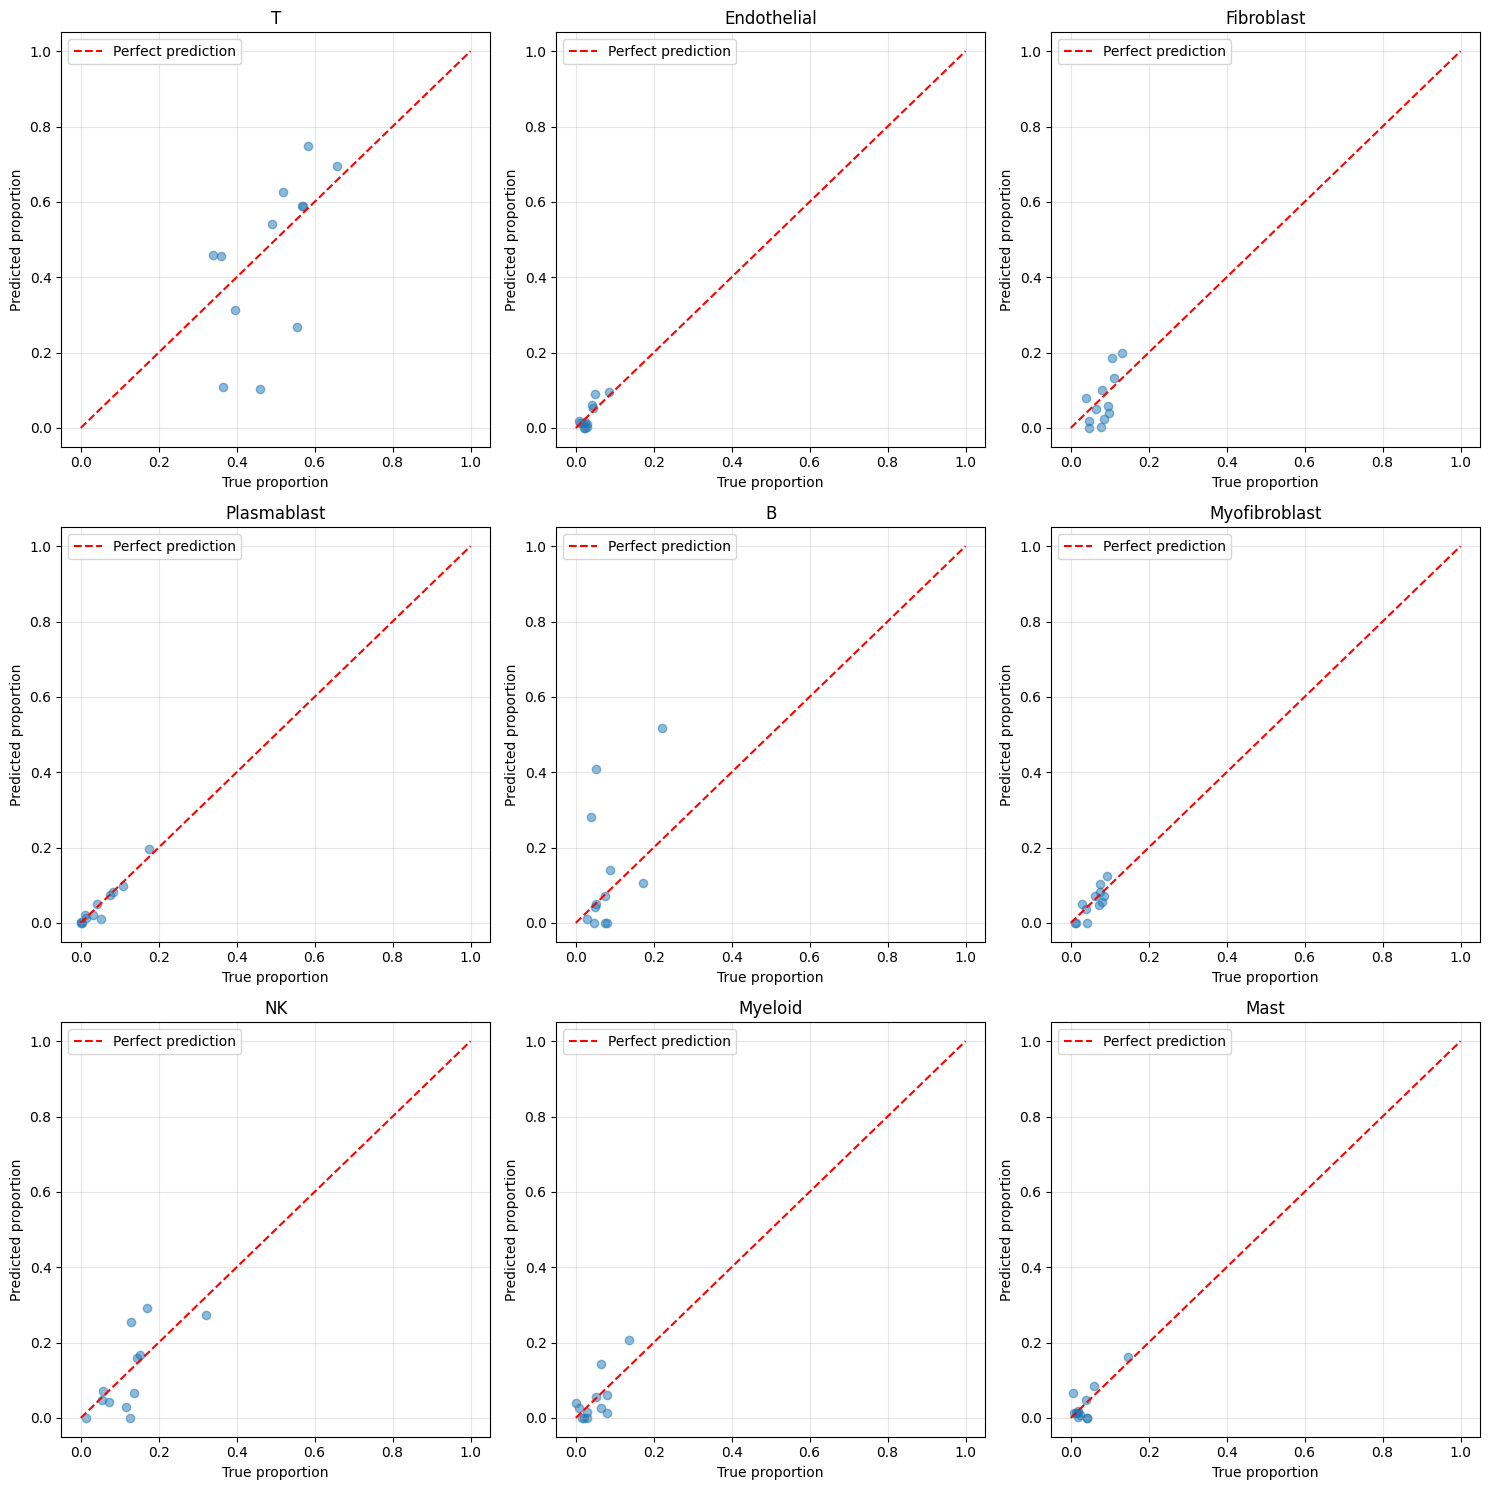

In [29]:
# Evaluate performance on training data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def task_benchmark_score(true_props: pd.DataFrame, pred_props: pd.DataFrame):
    mae = (true_props.values - pred_props.values) ** 2
    print("Mae mean:", mae.mean(axis=1))
    return np.sqrt(mae.mean(axis=1).astype('float32')).mean()

def evaluate_deconvolution(true_props, pred_props):
    """Calculate performance metrics for deconvolution"""
    # Ensure same ordesr
    common_samples = true_props.columns.intersection(pred_props.columns)
    common_celltypes = true_props.index.intersection(pred_props.index)
    
    true = true_props.loc[common_celltypes, common_samples]
    pred = pred_props.loc[common_celltypes, common_samples]
    
    mse = mean_squared_error(true.values.flatten(), pred.values.flatten())
    mae = mean_absolute_error(true.values.flatten(), pred.values.flatten())
    tb = task_benchmark_score(true, pred)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Task Benchmark Score (TB): {tb:.4f}")
    
    # Per cell type performance
    print("\nPer-cell-type MAE:")
    for ct in common_celltypes:
        ct_mae = mean_absolute_error(true.loc[ct], pred.loc[ct])
        print(f"  {ct}: {ct_mae:.4f}")
    
    return mae, rmse

print("Evaluation on training data:")
evaluate_deconvolution(train_bulk_trueprops, train_props_pred)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ct in enumerate(train_props_pred.index):
    ax = axes[idx]
    ax.scatter(train_bulk_trueprops.loc[ct], train_props_pred.loc[ct], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
    ax.set_xlabel('True proportion')
    ax.set_ylabel('Predicted proportion')
    ax.set_title(f'{ct}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [31]:
actual_ref_matrix.to_csv("data/train_data/reference_matrix.csv")

# Step 2: Perform clustering 

In [144]:
# Preprocessing
def sc_preprocess(sc_data):
    #sc.pp.filter_cells(sc_data, min_genes=200)
    sc.pp.filter_genes(sc_data, min_cells=3)
    #sc_data = sc_data[sc_data.obs['pct_counts_mt'] < 10]

    sc.pp.normalize_total(sc_data, target_sum=1e4)
    sc.pp.log1p(sc_data)

    sc.pp.highly_variable_genes(sc_data, n_top_genes=2000, batch_key="Sample")
    sc_data = sc_data[:, sc_data.var['highly_variable']]

    sc.pp.scale(sc_data, max_value=10)
    return sc_data

In [145]:
# PCA and batch correction with Harmony
def sc_batch_norm(sc_data):
    sc.tl.pca(sc_data, svd_solver='arpack')
    ho = hm.run_harmony(sc_data.obsm['X_pca'], sc_data.obs, 'Sample')
    sc_data.obsm['X_pca_harmony'] = ho.Z_corr.T
    return sc_data

In [146]:
def sc_cluster(sc_data):   
    sc.pp.neighbors(sc_data, use_rep='X_pca_harmony')
    sc.tl.leiden(sc_data, resolution=0.5)
    return sc_data

In [147]:
def sc_umap(sc_data):
    sc.tl.umap(sc_data, min_dist=0.3)
    sc.pl.umap(sc_data, color=['Sample', 'leiden'])

# Step 2bis: Predict on the test data

In [148]:
# SC pipeline
sc.pp.filter_genes(test_adata, min_cells=3)
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)
sc.pp.highly_variable_genes(test_adata, n_top_genes=2000, batch_key="Sample")
test_adata = test_adata[:, test_adata.var['highly_variable']]
sc.pp.scale(test_adata, max_value=10)

sc.tl.pca(test_adata, svd_solver='arpack')

ho = hm.run_harmony(test_adata.obsm['X_pca'], test_adata.obs, 'Sample')

test_adata.obsm['X_pca_harmony'] = ho.Z_corr.T

sc.pp.neighbors(test_adata, use_rep='X_pca_harmony')

sc.tl.leiden(test_adata, resolution=0.5)

2025-11-23 17:38:05,667 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-23 17:38:14,933 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-23 17:38:15,451 - harmonypy - INFO - Iteration 1 of 10
2025-11-23 17:38:25,996 - harmonypy - INFO - Iteration 2 of 10
2025-11-23 17:38:35,501 - harmonypy - INFO - Iteration 3 of 10
2025-11-23 17:38:44,991 - harmonypy - INFO - Iteration 4 of 10
2025-11-23 17:38:54,254 - harmonypy - INFO - Iteration 5 of 10
2025-11-23 17:39:05,882 - harmonypy - INFO - Converged after 5 iterations


In [149]:
cluster_labels = test_adata.obs
cluster_labels = cluster_labels.reset_index()
cluster_labels = cluster_labels[['index', 'leiden']]
cluster_labels.rename(columns={'leiden': 'cluster'}, inplace=True)

# Step 3: Save the required files

In [150]:
assert len(test_props_pred.columns) == len(test_bulk.columns) + 1, "Length mismatch: expected {} but got {}".format(len(test_bulk.columns) + 1, len(test_props_pred.columns))
assert all(test_props_pred.columns == np.append(["index"], test_bulk.columns)), "Wrong columns"

In [151]:
assert all(test_props_pred['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [152]:
assert all(test_props_pred.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [153]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [154]:
assert all(cluster_labels.columns == ["index", "cluster"]), "Wrong columns"

In [155]:
assert all(cluster_labels["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [156]:
import zipfile
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

from os import environ

first_name = environ.get('FIRST_NAME')
last_name = environ.get('LAST_NAME')
tstamp = datetime.now().strftime("%Y%m%d_%H%M%S")

results_path = pl.Path("data/submissions/")
archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_submission.zip"

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        test_props_pred.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()

print(f"Submission archive saved to {results_path / archive_name}")

archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_code.zip"

files_mapping = {
    "main.ipynb": "main.ipynb",
    "uv.lock": "uv.lock",
    ".python-version": ".python-version",
    "pyproject.toml": "pyproject.toml",
}

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    for fname, arcname in files_mapping.items():
        zf.write(fname, arcname)
    zf.close()

print(f"Code archive saved to {results_path / archive_name}")


Submission archive saved to data/submissions/20251123_173936_Paolo_Laffranchi_Project2_submission.zip
Code archive saved to data/submissions/20251123_173936_Paolo_Laffranchi_Project2_code.zip
